### Objective

> The current study seeks to propose an analytical approach that includes the use of a cloud computing technology that can allow the handling of data, extraction of basic statistical information based on the supplied data as well as enable the visualization of various aspects of the data in question. To this end, the study will use analytical pipelines which mainly involve processing datasets and producing readable reports exploring various issues including data quality, exploratory analysis, etcetera.

### Import Packages

In [19]:
import pandas as pd
#Timing execution time
import time

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')
from pyspark.sql import SparkSession
spark = SparkSession.builder.appName('Cloud Computing').getOrCreate()
import pandas as pd
import io
import os
#Install using pip install altair
import altair as altr
#Stats model package
import statsmodels.api as sm
#Altair
import altair as alt
#Matplotlib
import matplotlib.pyplot as plt
#Seaborn
import seaborn as sns
from pyspark.sql.functions import unix_timestamp, from_unixtime
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
#Numpy
import numpy as np

#Statistical computations
from scipy import stats
#Handling date conversion
import matplotlib.dates as conv_dates
from pyspark.sql.functions import col
from pyspark.sql.functions import exp
#Define a spark context

from pyspark.sql import SQLContext
sqlContext = SQLContext(spark)

### Import Data

In [20]:
%%time
#Ingest data
data = spark.read.csv('data/all_stocks_5yr.csv', header = True, inferSchema = True,nullValue='')
# Transform the date column
data = data.select(
    "*", 
    from_unixtime(unix_timestamp('date', 'yyyy-mm-dd')).alias('date1')
)
#Load
cols = ['date1', 'open', 'high', 'low', 'close', 'volume', 'Name']
data = data.select(*cols)
#Rename the date1 column
data = data.withColumnRenamed("date1","date")
#Convert to pandas for easy visualization 

## Add to pandas dataframe
dataa = data.toPandas()
dataa['Date'] = pd.to_datetime([item[0:4] for item in dataa.date], infer_datetime_format=True)
dataa = dataa.set_index('Date')
#Drop excess/duplicate columns
dataa = dataa.drop('date', axis = 1)
data.show()

+-------------------+-----+-----+-----+-----+--------+----+
|               date| open| high|  low|close|  volume|Name|
+-------------------+-----+-----+-----+-----+--------+----+
|2013-01-08 00:02:00|15.07|15.12|14.63|14.75| 8407500| AAL|
|2013-01-11 00:02:00|14.89|15.01|14.26|14.46| 8882000| AAL|
|2013-01-12 00:02:00|14.45|14.51| 14.1|14.27| 8126000| AAL|
|2013-01-13 00:02:00| 14.3|14.94|14.25|14.66|10259500| AAL|
|2013-01-14 00:02:00|14.94|14.96|13.16|13.99|31879900| AAL|
|2013-01-15 00:02:00|13.93|14.61|13.93| 14.5|15628000| AAL|
|2013-01-19 00:02:00|14.33|14.56|14.08|14.26|11354400| AAL|
|2013-01-20 00:02:00|14.17|14.26|13.15|13.33|14725200| AAL|
|2013-01-21 00:02:00|13.62|13.95| 12.9|13.37|11922100| AAL|
|2013-01-22 00:02:00|13.57| 13.6|13.21|13.57| 6071400| AAL|
|2013-01-25 00:02:00| 13.6|13.76| 13.0|13.02| 7186400| AAL|
|2013-01-26 00:02:00|13.14|13.42| 12.7|13.26| 9419000| AAL|
|2013-01-27 00:02:00|13.28|13.62|13.18|13.41| 7390500| AAL|
|2013-01-28 00:02:00|13.49|13.63|13.39|1

In [21]:
%%time
#Ingest data
data = spark.read.csv('data/all_stocks_5yr.csv', header = True, inferSchema = True,nullValue='')

Wall time: 1e+03 ms


In [22]:
data.printSchema()

root
 |-- date: string (nullable = true)
 |-- open: double (nullable = true)
 |-- high: double (nullable = true)
 |-- low: double (nullable = true)
 |-- close: double (nullable = true)
 |-- volume: integer (nullable = true)
 |-- Name: string (nullable = true)



#### Overview of data

In [23]:
%%time
data.show(5)

+----------+-----+-----+-----+-----+--------+----+
|      date| open| high|  low|close|  volume|Name|
+----------+-----+-----+-----+-----+--------+----+
|2013-02-08|15.07|15.12|14.63|14.75| 8407500| AAL|
|2013-02-11|14.89|15.01|14.26|14.46| 8882000| AAL|
|2013-02-12|14.45|14.51| 14.1|14.27| 8126000| AAL|
|2013-02-13| 14.3|14.94|14.25|14.66|10259500| AAL|
|2013-02-14|14.94|14.96|13.16|13.99|31879900| AAL|
+----------+-----+-----+-----+-----+--------+----+
only showing top 5 rows

Wall time: 210 ms


#### Summary Statistics

In [24]:
%%time
data.describe().show()

+-------+----------+----------------+-----------------+-----------------+-----------------+-----------------+------+
|summary|      date|            open|             high|              low|            close|           volume|  Name|
+-------+----------+----------------+-----------------+-----------------+-----------------+-----------------+------+
|  count|    619040|          619029|           619032|           619032|           619040|           619040|619040|
|   mean|      null|83.0233343145481|83.77831069347307|82.25609641375267|83.04376276476548|4321823.395568945|  null|
| stddev|      null|97.3787690433234|98.20751890446383|96.50742105809076|97.38974800165785| 8693609.51196759|  null|
|    min|2013-02-08|            1.62|             1.69|              1.5|             1.59|                0|     A|
|    max|2018-02-07|          2044.0|          2067.99|          2035.11|           2049.0|        618237630|   ZTS|
+-------+----------+----------------+-----------------+---------

#### Aggregate


- To determine the most traded stock

In [25]:
top_10 = data.groupBy("Name").sum("volume").sort(col("sum(volume)").desc())
top_10 = top_10.limit(10)
top_10.show(truncate=False)
top_101 = top_10.toPandas()

+----+------------+
|Name|sum(volume) |
+----+------------+
|BAC |117884953591|
|AAPL|68046305767 |
|GE  |53023644686 |
|F   |43388129992 |
|FB  |43258314899 |
|MSFT|42641653597 |
|AMD |40941468586 |
|MU  |38082749687 |
|INTC|36922332801 |
|CSCO|36075826186 |
+----+------------+



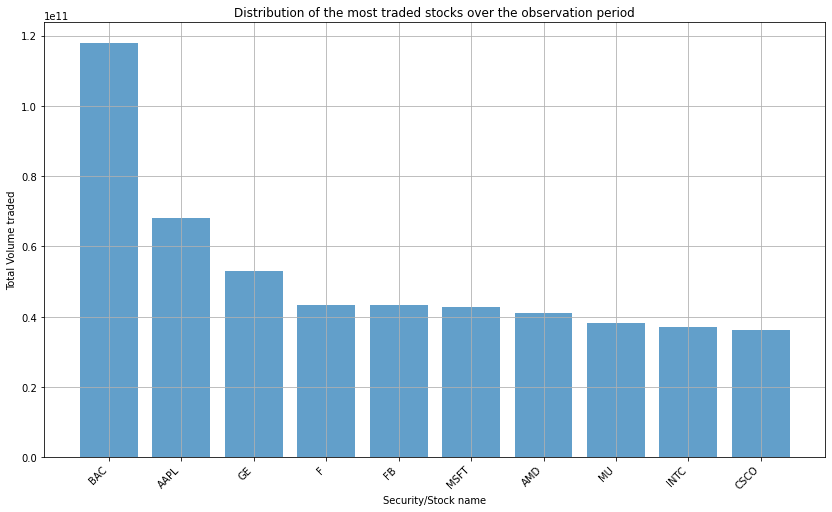

In [26]:
#!pip install pyspark_dist_explore
from pyspark_dist_explore import hist

#Bar plot
top_10_traded_stocks = top_101.sort_values(by= 'sum(volume)', ascending = False)
plt.rcParams['figure.figsize']=(14,8)
plt.bar(top_10_traded_stocks['Name'], top_10_traded_stocks['sum(volume)'], align='center', alpha=0.7)

plt.title('Distribution of the most traded stocks over the observation period')
plt.ylabel('Total Volume traded')
plt.xlabel('Security/Stock name')
plt.xticks(rotation=45, ha='right')
plt.grid(True)
plt.show();

### Data Handling

In [27]:
dataa.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 619040 entries, 2013-01-01 to 2018-01-01
Data columns (total 6 columns):
open      619029 non-null float64
high      619032 non-null float64
low       619032 non-null float64
close     619040 non-null float64
volume    619040 non-null int32
Name      619040 non-null object
dtypes: float64(4), int32(1), object(1)
memory usage: 30.7+ MB


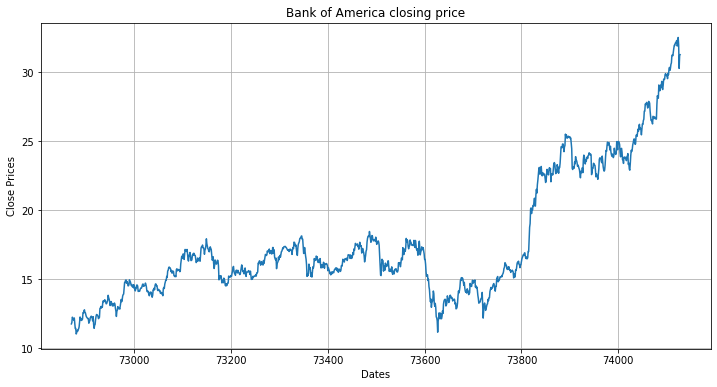

Wall time: 1.12 s


In [28]:
%%time
dataa = dataa.reset_index()
dataa1 = dataa[dataa['Name'] == 'BAC']
#plot close price
plt.figure(figsize=(12,6))
plt.grid(True)
plt.xlabel('Dates')
plt.ylabel('Close Prices')
plt.plot(dataa1['close'])
plt.title('Bank of America closing price')
plt.show()

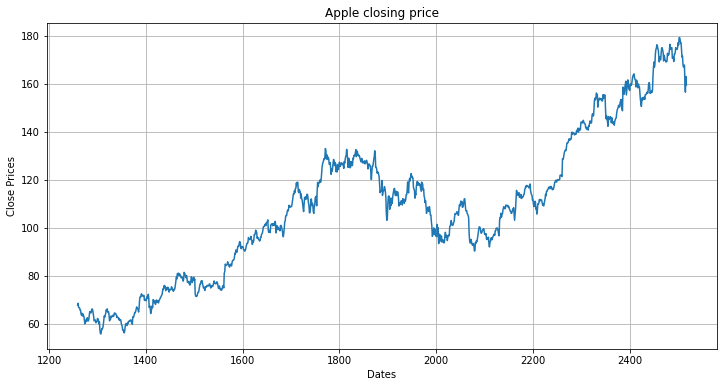

Wall time: 867 ms


In [29]:
%%time
dataa1 = dataa[dataa['Name'] == 'AAPL']
#plot close price
plt.figure(figsize=(12,6))
plt.grid(True)
plt.xlabel('Dates')
plt.ylabel('Close Prices')
plt.plot(dataa1['close'])
plt.title('Apple closing price')
plt.show()

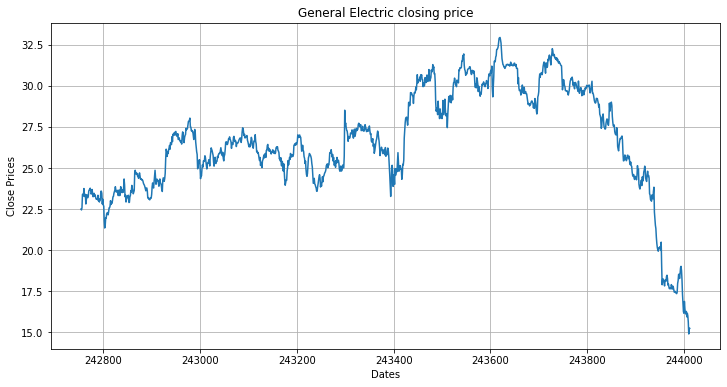

Wall time: 455 ms


In [30]:
%%time
dataa1 = dataa[dataa['Name'] == 'GE']
#plot close price
plt.figure(figsize=(12,6))
plt.grid(True)
plt.xlabel('Dates')
plt.ylabel('Close Prices')
plt.plot(dataa1['close'])
plt.title('General Electric closing price')
plt.show()

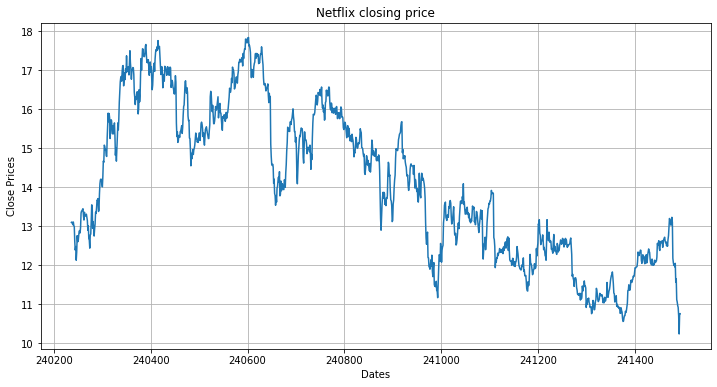

Wall time: 262 ms


In [31]:
%%time
dataa1 = dataa[dataa['Name'] == 'F']
#plot close price
plt.figure(figsize=(12,6))
plt.grid(True)
plt.xlabel('Dates')
plt.ylabel('Close Prices')
plt.plot(dataa1['close'])
plt.title('Netflix closing price')
plt.show()

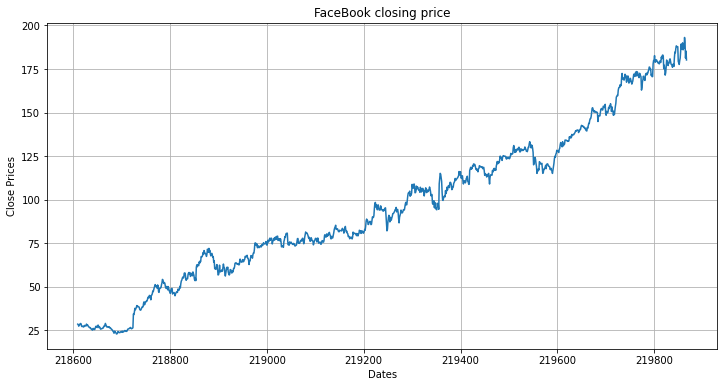

Wall time: 630 ms


In [32]:
%%time
dataa1 = dataa[dataa['Name'] == 'FB']
#plot close price
plt.figure(figsize=(12,6))
plt.grid(True)
plt.xlabel('Dates')
plt.ylabel('Close Prices')
plt.plot(dataa1['close'])
plt.title('FaceBook closing price')
plt.show()

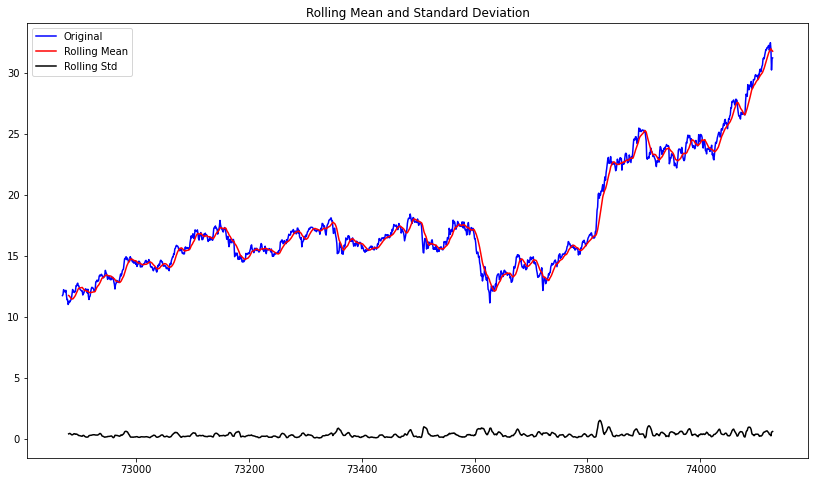

========Results of dickey fuller test========

Test Statistics                      0.671680
p-value                              0.989255
No. of lags Present                  2.000000
Number of observations present    1256.000000
critical value (1%)                 -3.435567
critical value (5%)                 -2.863844
critical value (10%)                -2.567997
dtype: float64


In [33]:
#this function is used to Test for staionarity
def examine_stationarity(timeseries):
    #Compute the rolling statistics
    rolmean = timeseries.rolling(12).mean()
    rolstd = timeseries.rolling(12).std()
    #Plot rolling statistics of the timeseries:
    #Timeseries
    plt.plot(timeseries, color='blue',label='Original')
    #Rolling mean
    plt.plot(rolmean, color='red', label='Rolling Mean')
    #Rolling standard deviation
    plt.plot(rolstd, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean and Standard Deviation')
    plt.show(block=False)
    
    print("========Results of dickey fuller test========\n")
    adft = adfuller(timeseries,autolag='AIC')
    # output for dft will give us without defining what the values are.
    #Manually define what the resulting values does using a for loop
    output = pd.Series(adft[0:4],index=['Test Statistics','p-value','No. of lags Present','Number of observations present'])
    for key,values in adft[4].items():
        output['critical value (%s)'%key] =  values
    print(output)
    print('=============================================')
    
examine_stationarity(dataa[dataa['Name'] == 'BAC'].close)

    We note that the p-value of the dickey fuller test is greater than 0.05 therefore, we fail to reject the Null hypothesis. And since, the test statistic is greater than the critical value we can conclude that the BAC time series is non-stationary.

    In order to perform a time series analysis, we may have to adopt additional analytical measures as shown below.


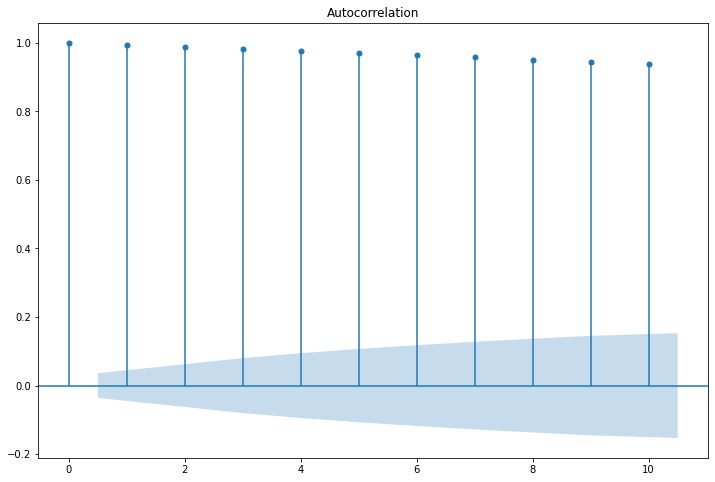

In [34]:
import statsmodels.api as sm
fig, ax = plt.subplots(figsize=(12, 8))
sm.graphics.tsa.plot_acf(dataa[dataa['Name'] == 'BAC'].close, lags=10, ax=ax, alpha=0.2);

We note from the acf plot given above that the data has some correlation from the first lag hence we will use a modified Mann-Kendall test that handles correlation such as Hamed and Rao Modified MK (Blain, 2013).

In [35]:
#!pip install pymannkendall
import pymannkendall as pmk
pmk.hamed_rao_modification_test(dataa[dataa['Name'] == 'BAC'].close)

Modified_Mann_Kendall_Test_Hamed_Rao_Approach(trend='increasing', h=True, p=0.0039851528886285514, z=2.879334588853187, Tau=0.5300166306567279, s=419726.0, var_s=21249338108.10666, slope=0.009461279461279464, intercept=10.298855218855216)

In [36]:

from IPython.display import HTML

HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
<form action="javascript:code_toggle()"><input type="submit" value="Click here to toggle on/off the raw code."></form>''')